# Adversarial VAE detection on MNIST

## Method

The adversarial VAE detector is first trained on a batch of unlabeled but normal (*not adversarial*) data. The loss is however different from traditional VAE training and focuses on minimizing the KL-divergence between a classifier's predictions on the original and reconstructed data. When an adversarial instance is fed to the VAE, the KL-divergence between the predictions on the adversarial example and the reconstruction is large. The reconstruction does not contain the adversarial artefacts and has a very different prediction distribution. As a result, the adversarial instance is flagged.

## Dataset

traffic signs

In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
import zipfile
import logging

from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
# Adversarial attack method. The latest release of the `cleverhans` package does
# not support TensrFlow 2 yet, so we need to install from the master branch:
# pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.future.tf2.attacks import projected_gradient_descent

from alibi_detect.datasets import fetch_traffic_signs
from alibi_detect.models.losses import loss_adv_vae
from alibi_detect.ad import AdversarialVAE
from alibi_detect.utils.saving import save_detector, load_detector, save_tf_model, load_tf_model
from alibi_detect.utils.visualize import plot_instance_score

tf.keras.backend.clear_session()
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
from inspect import signature
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
%matplotlib inline
from scipy.stats import percentileofscore
from importlib import reload

# Load traffic signs data

In [3]:
"""def fetch_traffic_signs(data_folder="../data/"):
    
    with zipfile.ZipFile(os.path.join(data_folder, 'gtsrb-german-traffic-sign.zip'),"r") as zip_ref:
        zip_ref.extractall(data_folder)
    train_folder = data_folder+'train/'
    
    data=[]
    labels=[]

    height = 32
    width = 32
    channels = 3
    classes = 43
    n_inputs = height * width*channels

    for i in range(classes) :
        path = train_folder+"{0}/".format(i)
        print(path)
        Class=os.listdir(path)
        for a in Class:
            try:
                image=cv2.imread(path+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
                labels.append(i)
            except AttributeError:
                print(" ")
            
    Cells=np.array(data)
    labels=np.array(labels)

    #Randomize the order of the input images
    s=np.arange(Cells.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    Cells=Cells[s]
    labels=labels[s]

    (X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]

    (y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]
    
    train, test = (X_train, y_train), (X_val, y_val)
    
    return train, test
"""

'def fetch_traffic_signs(data_folder="../data/"):\n    \n    with zipfile.ZipFile(os.path.join(data_folder, \'gtsrb-german-traffic-sign.zip\'),"r") as zip_ref:\n        zip_ref.extractall(data_folder)\n    train_folder = data_folder+\'train/\'\n    \n    data=[]\n    labels=[]\n\n    height = 32\n    width = 32\n    channels = 3\n    classes = 43\n    n_inputs = height * width*channels\n\n    for i in range(classes) :\n        path = train_folder+"{0}/".format(i)\n        print(path)\n        Class=os.listdir(path)\n        for a in Class:\n            try:\n                image=cv2.imread(path+a)\n                image_from_array = Image.fromarray(image, \'RGB\')\n                size_image = image_from_array.resize((height, width))\n                data.append(np.array(size_image))\n                labels.append(i)\n            except AttributeError:\n                print(" ")\n            \n    Cells=np.array(data)\n    labels=np.array(labels)\n\n    #Randomize the order of the in

In [4]:
#!gsutil cp gs://seldon-datasets/traffic/
#!mv 'gtsrb-german-traffic-sign.zip' ../data/traffic/.

In [5]:
bunch = fetch_traffic_signs(data_folder='../data/traffic/')
X_train, y_train = bunch.train
X_val, y_val = bunch.val
X_test, y_test = bunch.test

X_train = X_train.reshape(-1, 32, 32, 3).astype('float32') / 255
X_val = X_val.reshape(-1, 32, 32, 3).astype('float32') / 255
X_test = X_test.reshape(-1, 32, 32, 3).astype('float32') / 255
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#classes = ('0', '1', '2', '3',
#           '4', '5', '6', '7', '8', '9')
img_shape = (28, 28)


INFO:alibi_detect.datasets:Unzipping file ...
INFO:alibi_detect.datasets:Extracting images


/tmp/tmpowqqvw6c/train/0/
/tmp/tmpowqqvw6c/train/1/
/tmp/tmpowqqvw6c/train/2/
/tmp/tmpowqqvw6c/train/3/
/tmp/tmpowqqvw6c/train/4/
/tmp/tmpowqqvw6c/train/5/
/tmp/tmpowqqvw6c/train/6/
/tmp/tmpowqqvw6c/train/7/
/tmp/tmpowqqvw6c/train/8/
/tmp/tmpowqqvw6c/train/9/
/tmp/tmpowqqvw6c/train/10/
/tmp/tmpowqqvw6c/train/11/
/tmp/tmpowqqvw6c/train/12/
/tmp/tmpowqqvw6c/train/13/
/tmp/tmpowqqvw6c/train/14/
/tmp/tmpowqqvw6c/train/15/
/tmp/tmpowqqvw6c/train/16/
/tmp/tmpowqqvw6c/train/17/
/tmp/tmpowqqvw6c/train/18/
/tmp/tmpowqqvw6c/train/19/
/tmp/tmpowqqvw6c/train/20/
/tmp/tmpowqqvw6c/train/21/
/tmp/tmpowqqvw6c/train/22/
/tmp/tmpowqqvw6c/train/23/
/tmp/tmpowqqvw6c/train/24/
/tmp/tmpowqqvw6c/train/25/
/tmp/tmpowqqvw6c/train/26/
/tmp/tmpowqqvw6c/train/27/
/tmp/tmpowqqvw6c/train/28/
/tmp/tmpowqqvw6c/train/29/
/tmp/tmpowqqvw6c/train/30/
/tmp/tmpowqqvw6c/train/31/
/tmp/tmpowqqvw6c/train/32/
/tmp/tmpowqqvw6c/train/33/
/tmp/tmpowqqvw6c/train/34/
/tmp/tmpowqqvw6c/train/35/
/tmp/tmpowqqvw6c/train/36/
/tmp/tmpowq

/home/fdz/git/fork-alibi-detect/alibi_detect/datasets.py:61: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  labels_test = y_test['Path'].as_matrix()


(31368, 32, 32, 3) (31368, 43) (12630, 32, 32, 3) (12630, 43)


### Show example

Sample instance from the signs data set.


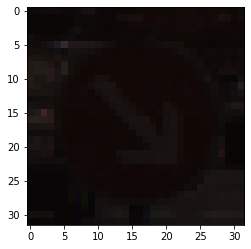

In [6]:
idx = 4200
x = X_train[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the signs data set.')

## Create and train traffic signs model

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can either manually download the relevant files in the [model_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/model_mnist/) folder to e.g. the local directory ```my_dir```. Alternatively,  if you have [Google Cloud SDK](https://cloud.google.com/sdk/docs/) installed, you can download the whole folder as follows:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/model_mnist my_dir
```

In [7]:
load_signs_model = False

In [8]:
filepath = './model_signs/'
if load_signs_model:
    model = load_tf_model(filepath)
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]))
    x = Conv2D(64, 5, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(43, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    
    #inputs = Input(shape=(X_train.shape[1:]))
    #x = Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(inputs)
    #x = Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    #
    #x = Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    #x = Flatten()(x)
    #x = Dense(256, activation='relu')(x)
    #x = Dropout(0.5)(x)
    #logits = Dense(43, name='logits')(x)
    #outputs = Activation('softmax', name='softmax')(logits)
    #model = Model(inputs=inputs, outputs=outputs)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam',
    #              metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=5,
              batch_size=256,
              verbose=1,
              validation_data=(X_val, y_val)
              )
    
    # save model
    save_tf_model(model, filepath)

Train on 31368 samples, validate on 7841 samples
Epoch 1/5
31368/31368 [==============================] - 37s 1ms/sample - loss: 2.6724 - accuracy: 0.2815 - val_loss: 1.4700 - val_accuracy: 0.5937
Epoch 2/5
31368/31368 [==============================] - 39s 1ms/sample - loss: 1.1829 - accuracy: 0.6388 - val_loss: 0.6179 - val_accuracy: 0.8320
Epoch 3/5
31368/31368 [==============================] - 39s 1ms/sample - loss: 0.6772 - accuracy: 0.7853 - val_loss: 0.3192 - val_accuracy: 0.9279
Epoch 4/5
31368/31368 [==============================] - 38s 1ms/sample - loss: 0.4674 - accuracy: 0.8501 - val_loss: 0.2069 - val_accuracy: 0.9554
Epoch 5/5
31368/31368 [==============================] - 39s 1ms/sample - loss: 0.3610 - accuracy: 0.8840 - val_loss: 0.1546 - val_accuracy: 0.9640


In [9]:
# evaluate model
results = model.evaluate(X_val, y_val, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 0.1546 -- accuracy: 0.9640


In [10]:
# evaluate model
results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 0.3347 -- accuracy: 0.9063


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0     

In [12]:
probs = model(X_test).numpy()

In [13]:
probs.shape

(12630, 43)

In [14]:
probs.max(axis=1).mean()

0.8696434

## Train Adversarial VAE for MNIST

You can again either manually download the relevant files in the [ad_vae_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad_vae_mnist/) folder to e.g. the local directory ```my_dir``` or use ```gsutil```:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/ad_vae_mnist my_dir
```

In [15]:
load_adversarial_detector = False

In [16]:
#encoder_net = tf.keras.Sequential(
#    [
#        InputLayer(input_shape=(32, 32, 3)),
#        Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
#        #x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
#        MaxPooling2D(pool_size=(2, 2)),
#        Dropout(0.25),
#        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
#        MaxPooling2D(pool_size=(2, 2)),
#        Dropout(0.25)
#    ]
#)

In [126]:
filepath = './ad_vae_signs/'
if load_adversarial_detector:  # load pretrained adversarial detector
    ad = load_detector(filepath)
else:  # define model, initialize, train and save adversarial detector
    latent_dim = 50
    
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])
    
    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(8*8*32, activation=tf.nn.relu),
          Reshape(target_shape=(8, 8, 32)),
          Conv2DTranspose(64, 3, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(32, 3, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 3, strides=1, padding='same', activation='sigmoid')
      ])
    
    # initialize adversarial detector
    ad = AdversarialVAE(threshold=.5,  # threshold for adversarial score
                        model=model,
                        encoder_net=encoder_net,  # can also pass VAE model instead
                        decoder_net=decoder_net,  # of separate encoder and decoder
                        latent_dim=latent_dim,
                        samples=2,  # nb of samples drawn by VAE
                        beta=0.  # weight on KL-divergence loss term of latent space
                       )
    

In [127]:
encoder_net.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 16, 16, 64)        3136      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)         131200    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 512)         1049088   
Total params: 1,183,424
Trainable params: 1,183,424
Non-trainable params: 0
_________________________________________________________________


In [128]:
decoder_net.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 2048)              104448    
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 32, 32, 3)         867       
Total params: 142,275
Trainable params: 142,275
Non-trainable params: 0
_________________________________________________________________


In [129]:
if not load_adversarial_detector:
    # train
    ad.fit(X_train,
           loss_fn=loss_adv_vae,
           w_model=1.,  # weight on KL-divergence loss term of model predictions
           w_recon=0.,  # weight on elbo loss term
           optimizer=Adam(),
           epochs=2,
           verbose=True)
    
    # save the trained outlier detector
    save_detector(ad, filepath)

491/491 [=] - 190s 388ms/step - loss: 0.1645


## Generate adversarial instances

The `cleverhans` adversarial attack methods assume that the model outputs logits, so we will create a modified model by simply removing the softmax output layer:

In [108]:
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [109]:
nb_adv = 500
ids = np.arange(nb_adv)
np.random.shuffle(ids)
X_to_adv = X_val[ids]
y_adv = y_val[ids]
print(X_to_adv.shape)

(500, 32, 32, 3)


In [110]:
X_adv = projected_gradient_descent(model_logits, ad, 0,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()

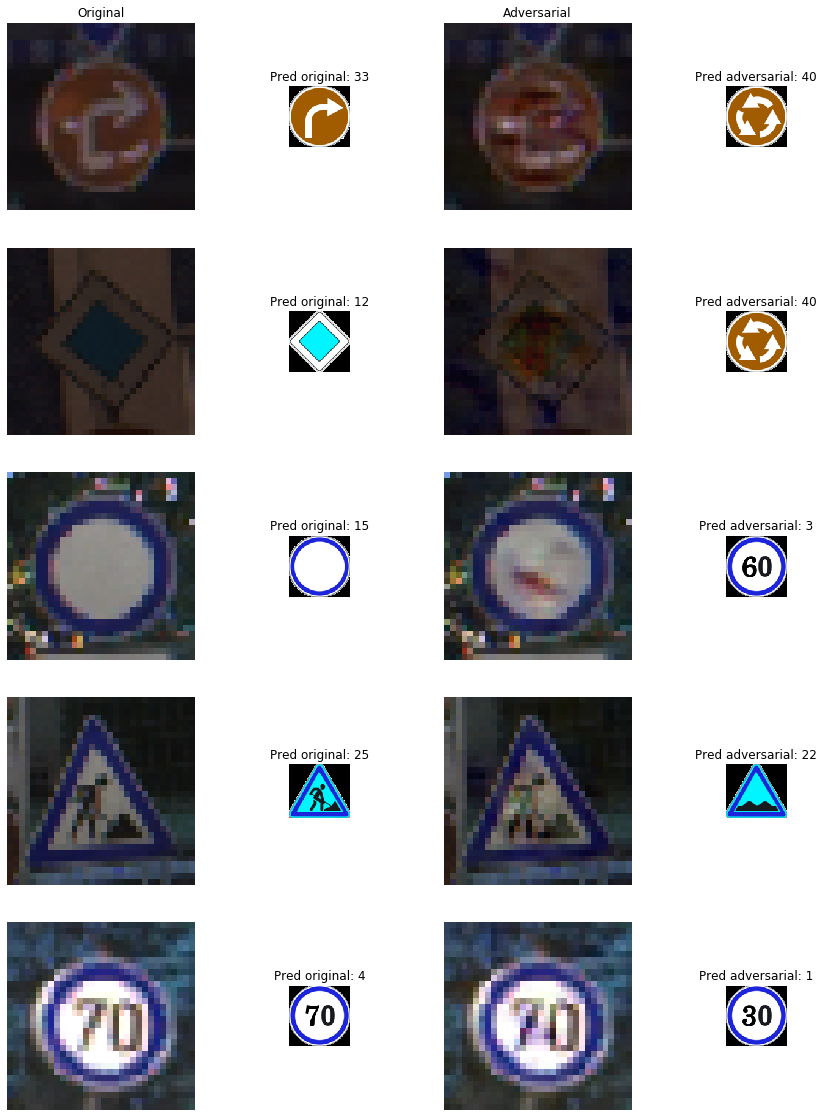

In [111]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (32, 32, 3)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    image = Image.fromarray(class_image, 'RGB')
    image = np.array(image)
    ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    image_adv = Image.fromarray(class_image_adv, 'RGB')
    image_adv = np.array(image_adv)   
    ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

## Detect adversarial instances# Detect Advs

In [112]:
X_to_adv = X_to_adv[(y_pred != y_pred_adv)]
X_adv = X_adv[(y_pred != y_pred_adv)]

In [113]:
X = np.concatenate([X_to_adv, X_adv], axis=0)
print(X.shape)

(936, 32, 32, 3)


In [114]:
ad.infer_threshold(X_train[:2000], threshold_perc=90.)

In [115]:
ad_preds = ad.predict(X, return_instance_score=True)

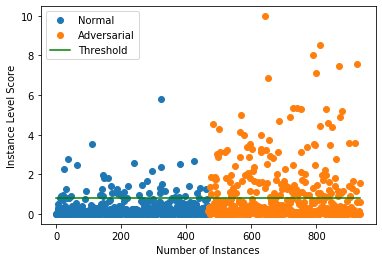

In [116]:
labels = ['Normal', 'Adversarial']
target = np.array([0 if i < X_to_adv.shape[0] else 1 for i in range(X.shape[0])])
plot_instance_score(ad_preds, target, labels, ad.threshold)

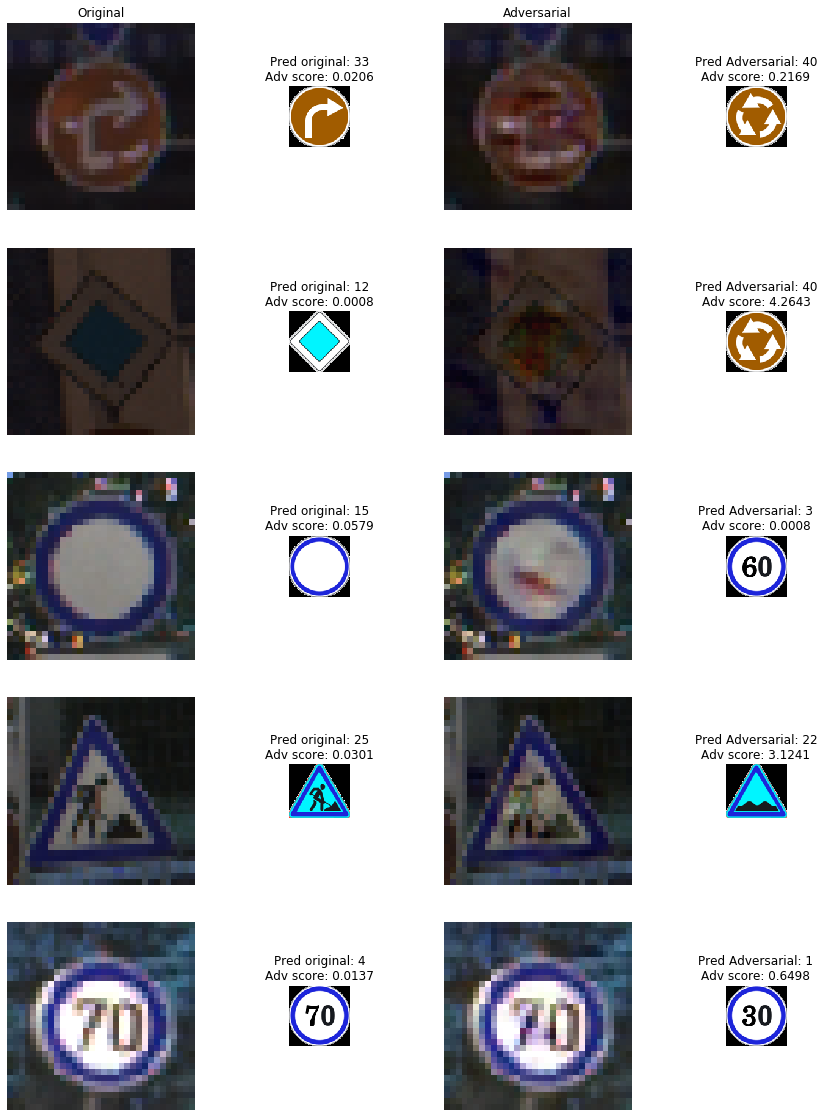

In [117]:
scores = ad_preds['data']['instance_score']
fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')  
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    image = Image.fromarray(class_image, 'RGB')
    image = np.array(image)
    ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'
                  '\nAdv score: {:.4f}'.format(y_pred[row], scores[row]))    
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    image_adv = Image.fromarray(class_image_adv, 'RGB')
    image_adv = np.array(image_adv)   
    ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred Adversarial: {}'
                  '\nAdv score: {:.4f}'.format(y_pred_adv[row], scores[row + nb_adv]))    
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

# Adversarial detection performances

In [118]:
kl_test_dict = ad.predict(X_to_adv, return_instance_score=True)
kl_test = kl_test_dict['data']['instance_score']
kl_adv_dict = ad.predict(X_adv, return_instance_score=True)
kl_adv = kl_adv_dict['data']['instance_score']

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [119]:
print(kl_test.shape, kl_adv.shape)
print(kl_test.mean(), kl_test.std())
print(kl_adv.mean(), kl_adv.std())

(468,) (468,)
0.28276306 0.52437884
0.856299 1.4694581


In [120]:
preds_ad_test = kl_test_dict['data']['is_adversarial']
preds_ad_adv = kl_adv_dict['data']['is_adversarial']
preds_ad = np.concatenate((preds_ad_test, preds_ad_adv))
y_true_ad = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv))))

In [121]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad, preds_ad))

Adversarial detection accuracy: 0.5993589743589743


In [122]:
print('Adversarial detection f1:', f1_score(y_true_ad, preds_ad))

Adversarial detection f1: 0.4221879815100154


## Curves

In [40]:
def predict_adv(x, tr):
    return (x > tr).astype(int)

def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

def calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=100, nb_sigmas=3):
    
    X_train_samples = np.random.permutation(X_train)[:nb_samples]
    preds_train = predict_fn(X_train_samples)
    nn = NearestNeighbors()
    nn.fit(preds_train)
    
    preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
    dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
    dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

    df_dist = pd.DataFrame()
    df_dist['test'] = dist_test.flatten()
    df_dist['adv'] = dist_adv.flatten()
    
    perc, sigma_plus = _calculate_perc(df_dist, nb_sigmas=nb_sigmas)
    
    return perc, df_dist, sigma_plus

def predict_fn(x):
    return model.predict(x)

In [41]:
perm = np.random.permutation(range(len(kl_adv)))[:500]
x_kl = np.concatenate((kl_test, kl_adv[perm]))
y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv[perm]))))
x_kl = x_kl / x_kl.max()

In [42]:
perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_to_adv, X_adv, predict_fn, nb_samples=1000, nb_sigmas=5)
dist_test, dist_adv = df_dist['test'].values, df_dist['adv'].values
x_bl =  np.concatenate((dist_test, dist_adv[perm]))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv[perm]))))
x_bl = x_bl / x_bl.max()

### Precision recall curves

Naive detector baseline


(0.0, 1.0)

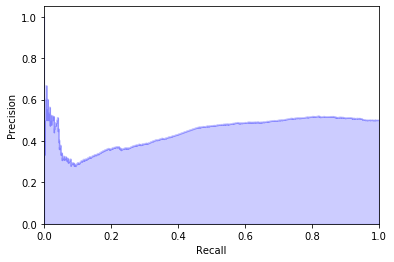

In [43]:
print('Naive detector baseline')
precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_bl, x_bl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_bl, precision_bl, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_bl, precision_bl, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

Vae detector


(0.0, 1.0)

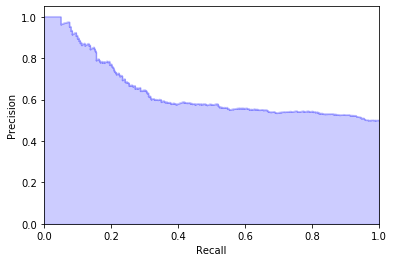

In [44]:
print('Vae detector')
precision, recall, thresholds = precision_recall_curve(y_kl, x_kl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

### Accuracy - f1 scores

In [45]:
trs = np.arange(0, 1.001, 0.001)
tresholds, precs, recals, accs, f1s = [], [], [], [], []
precs_bl, recals_bl, accs_bl, f1s_bl = [], [], [], []
for tr in trs:
    preds_kl = predict_adv(x_kl, tr)
    preds_bl = predict_adv(x_bl, tr)
    
    prec = precision_score(y_kl, preds_kl)
    rec = recall_score(y_kl, preds_kl)
    acc = accuracy_score(y_kl, preds_kl)
    f1 = f1_score(y_kl, preds_kl)
    
    prec_bl = precision_score(y_bl, preds_bl)
    rec_bl = recall_score(y_bl, preds_bl)
    acc_bl = accuracy_score(y_bl, preds_bl)
    f1_bl = f1_score(y_bl, preds_bl)
    
    tresholds.append(tr)
    precs.append(prec)
    recals.append(rec)
    accs.append(acc)
    f1s.append(f1)
    
    precs_bl.append(prec_bl)
    recals_bl.append(rec_bl)
    accs_bl.append(acc_bl)
    f1s_bl.append(f1_bl)

df_scores = pd.DataFrame()
df_scores['trs'] = tresholds
df_scores['precs'] = precs
df_scores['recs'] = recals
df_scores['accs'] = accs
df_scores['f1s'] = f1s

df_scores['precs_bl'] = precs_bl
df_scores['recs_bl'] = recals_bl
df_scores['accs_bl'] = accs_bl
df_scores['f1s_bl'] = f1s_bl

/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy


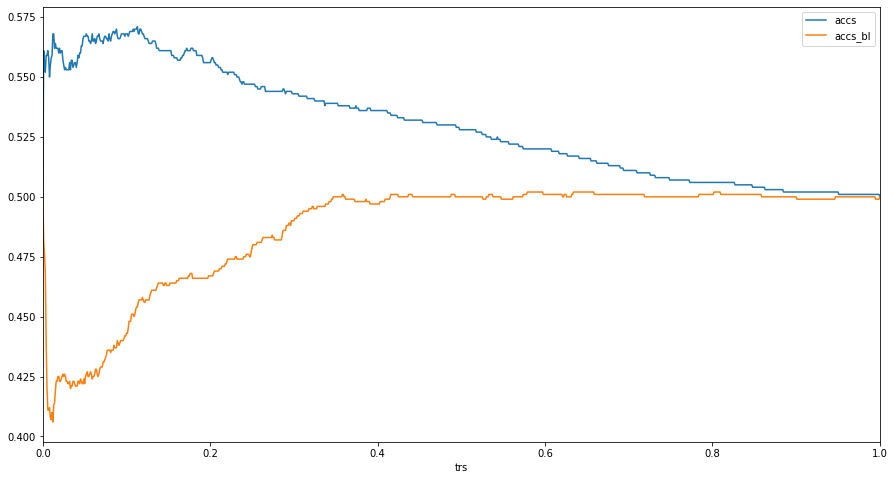

In [46]:
print('Accuracy')
df_scores.plot(x= 'trs',y=['accs', 'accs_bl'], figsize=(15, 8))

F1 score


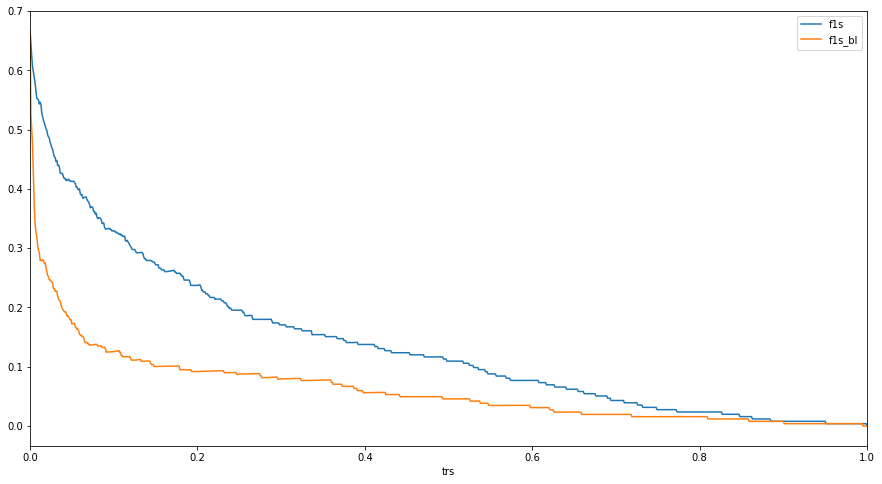

In [47]:
print('F1 score')
df_scores.plot(x= 'trs',y=['f1s', 'f1s_bl'], figsize=(15, 8))

In [48]:
df_scores.describe()

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.500000,0.919279,0.088498,0.529575,0.138603,0.450139,0.039121,0.486734,0.061807
std,0.289108,0.120466,0.109650,0.021953,0.129629,0.104494,0.060105,0.023541,0.065482
min,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.406000,0.000000
25%,0.250000,0.873016,0.014000,0.507000,0.027613,0.337500,0.008000,0.480000,0.015748
50%,0.500000,0.971429,0.058000,0.528000,0.109434,0.500000,0.024000,0.500000,0.045802
75%,0.750000,1.000000,0.110000,0.547000,0.195382,0.500000,0.050000,0.500000,0.088183
max,1.000000,1.000000,1.000000,0.571000,0.666667,0.666667,1.000000,0.502000,0.666667


### Distributions

Vae detector


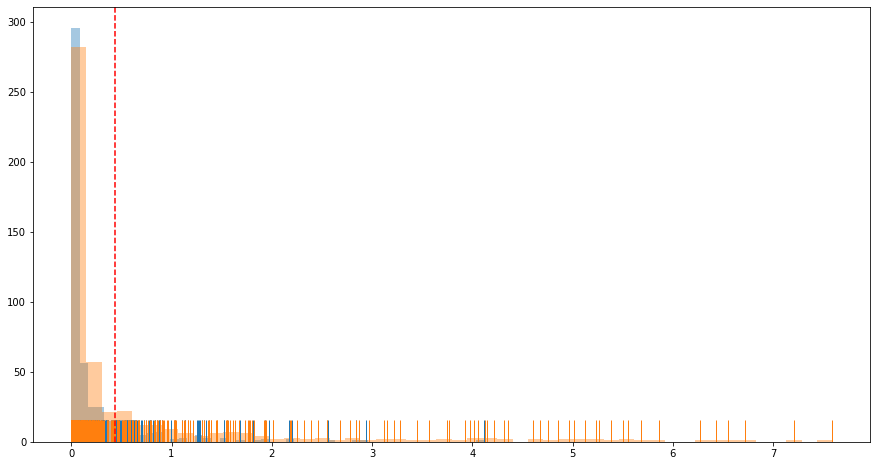

In [49]:
print('Vae detector')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(kl_adv, rug=True,ax=ax, kde=False)

Naive detector baseline


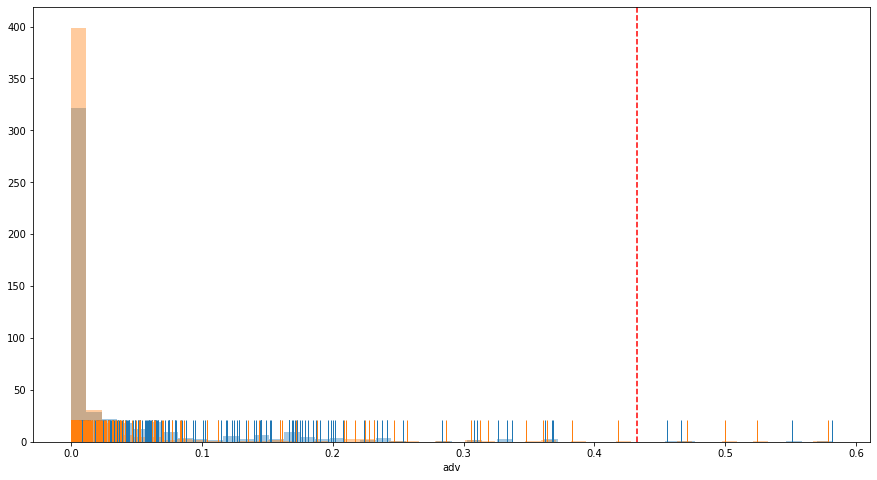

In [50]:
print('Naive detector baseline')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_dist['test'], rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(df_dist['adv'], rug=True,ax=ax, kde=False)